# Assignment Part 1

# Byte Pair Encoding (BPE) Implementation and Evaluation on NLTK Dataset

In [1]:
import re
from collections import defaultdict, Counter
import nltk
from nltk.corpus import gutenberg
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

## 1. BPE Algorithm

In [2]:
class BytePairEncoding:
    def __init__(self, vocab=None, num_merges=10):
        self.vocab = vocab or {}
        self.num_merges = num_merges
        self.bpe_merges = []

    def _get_stats(self):
        """Count frequency of adjacent symbol pairs in the vocabulary."""
        pairs = defaultdict(int)
        for word, freq in self.vocab.items():
            symbols = word.split()
            for i in range(len(symbols) - 1):
                pairs[(symbols[i], symbols[i + 1])] += freq
        return pairs

    def _merge_vocab(self, pair):
        """Merge the most frequent pair into a single symbol in the vocabulary."""
        new_vocab = {}
        bigram = re.escape(' '.join(pair))
        pattern = re.compile(rf'(?<!\S){bigram}(?!\S)')
        for word in self.vocab:
            new_word = pattern.sub(''.join(pair), word)
            new_vocab[new_word] = self.vocab[word]
        return new_vocab

    def learn_bpe(self):
        """Learn the Byte Pair Encoding merges."""
        for _ in range(self.num_merges):
            pairs = self._get_stats()
            if not pairs:
                break
            best_pair = max(pairs, key=pairs.get)
            self.bpe_merges.append(best_pair)
            self.vocab = self._merge_vocab(best_pair)

    def encode(self, word):
        """Encode a word using the learned BPE merges."""
        symbols = list(word)
        for pair in self.bpe_merges:
            i = 0
            while i < len(symbols) - 1:
                if (symbols[i], symbols[i + 1]) == pair:
                    symbols[i:i + 2] = [''.join(pair)]
                else:
                    i += 1
        return symbols

    def decode(self, encoded_word):
        """Decode a word by splitting merged symbols back into individual characters."""
        decoded = ' '.join(encoded_word)
        for pair in reversed(self.bpe_merges):
            merged = ''.join(pair)
            decoded = decoded.replace(merged, ' '.join(pair))
        return decoded.replace(' ', '')

In [3]:
# Helper Functions
def preprocess_text(text):
    """Preprocess text to create a vocabulary with word frequencies."""
    words = text.lower().split()
    vocab = Counter([' '.join(word) for word in words])
    return dict(vocab)

def train_bpe_on_corpus(corpus, num_merges=50):
    """Train BPE on a given corpus."""
    vocab = preprocess_text(corpus)
    bpe = BytePairEncoding(vocab, num_merges=num_merges)
    bpe.learn_bpe()
    return bpe


# Helper function to calculate metrics
def evaluate_tokenization(reference_tokens, test_tokens):
    """
    Evaluate tokenization results using Precision, Recall, F1, and Jaccard Similarity.
    Args:
        reference_tokens (list of str): The ground truth tokens (baseline).
        test_tokens (list of str): The tokens generated by the BPE algorithm.
    Returns:
        dict: A dictionary containing Precision, Recall, F1, and Jaccard scores.
    """
    # Flatten token lists to handle all tokens together
    reference_set = set(reference_tokens)
    test_set = set(test_tokens)

    # Calculate metrics
    precision = len(reference_set & test_set) / len(test_set) if test_set else 0
    recall = len(reference_set & test_set) / len(reference_set) if reference_set else 0
    f1 = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0
    jaccard = len(reference_set & test_set) / len(reference_set | test_set) if reference_set | test_set else 0

    return {
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Jaccard Similarity": jaccard,
    }

## 2. Train on NLTK Dataset

In [4]:
import nltk

# Download the NLTK Gutenberg Corpus
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/prudhvivuda/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [5]:
# Import the Gutenberg Corpus module
from nltk.corpus import gutenberg

# Get the list of available books in the Gutenberg Corpus
book_list = gutenberg.fileids()
book_list

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [6]:
# Load a specific book (e.g., "shakespeare-hamlet.txt")
selected_book = gutenberg.raw('shakespeare-hamlet.txt')

# Display the first 500 characters of the selected book
print("\nSample Text from 'shakespeare-hamlet.txt':")
print(selected_book[:500])


Sample Text from 'shakespeare-hamlet.txt':
[The Tragedie of Hamlet by William Shakespeare 1599]


Actus Primus. Scoena Prima.

Enter Barnardo and Francisco two Centinels.

  Barnardo. Who's there?
  Fran. Nay answer me: Stand & vnfold
your selfe

   Bar. Long liue the King

   Fran. Barnardo?
  Bar. He

   Fran. You come most carefully vpon your houre

   Bar. 'Tis now strook twelue, get thee to bed Francisco

   Fran. For this releefe much thankes: 'Tis bitter cold,
And I am sicke at heart

   Barn. Haue you had quiet Guard?
  Fran. Not


In [7]:
# Load and preprocess training and test corpora
# training_books = ["austen-emma.txt", "blake-poems.txt", "shakespeare-hamlet.txt"]
# test_books = ["austen-sense.txt", "shakespeare-macbeth.txt", "whitman-leaves.txt"]

training_books = ['austen-emma.txt','austen-persuasion.txt','austen-sense.txt']
test_books = [ 'bible-kjv.txt', 'blake-poems.txt','bryant-stories.txt']

training_corpus = " ".join([gutenberg.raw(book) for book in training_books])
test_corpus = " ".join([gutenberg.raw(book) for book in test_books])

# Train BPE on training corpus
bpe = train_bpe_on_corpus(training_corpus, num_merges=100)
print("Learned BPE Merges:", bpe.bpe_merges)

Learned BPE Merges: [('h', 'e'), ('i', 'n'), ('a', 'n'), ('t', 'he'), ('r', 'e'), ('o', 'u'), ('o', 'n'), ('e', 'r'), ('h', 'a'), ('i', 't'), ('t', 'o'), ('e', 'n'), ('a', 's'), ('e', 'd'), ('an', 'd'), ('i', 's'), ('in', 'g'), ('o', 'f'), ('o', 'r'), ('b', 'e'), ('l', 'l'), ('a', 't'), ('n', 'o'), ('a', 'r'), ('t', 'h'), ('l', 'e'), ('s', 't'), ('s', 'e'), ('he', 'r'), ('o', 'm'), ('v', 'e'), ('l', 'd'), ('c', 'h'), ('v', 'er'), ('w', 'as'), ('l', 'y'), ('ha', 't'), ('s', 'he'), ('y', 'ou'), ('c', 'e'), ('g', 'h'), ('f', 'or'), ('w', 'e'), ('no', 't'), ('i', 'on'), ('h', 'i'), ('en', 't'), ('d', 'e'), ('a', 'l'), ('-', '-'), ('ou', 'ld'), ('n', 'e'), ('m', 'e'), ('s', 'u'), ('t', 'hat'), ('u', 't'), ('ha', 'd'), ('a', 'll'), ('a', 'y'), ('it', 'h'), ('i', 'r'), ('w', 'ith'), ('r', 'i'), ('s', 's'), ('c', 't'), ('l', 'i'), ('ver', 'y'), ('gh', 't'), ('s', 'o'), ('the', 'r'), ('m', 'r'), ('i', 'd'), ('f', 'e'), ('b', 'ut'), ('r', 'o'), ('h', 'o'), ('h', 'is'), ('t', 'er'), ('s', ','), (

In [8]:
# Encode and decode a sample word
sample_word = "Frankenstein"

encoded = bpe.encode(sample_word)
print(f"Encoded '{sample_word}':", encoded)

decoded = bpe.decode(encoded)
print(f"Decoded back: '{decoded}'")

Encoded 'Frankenstein': ['F', 'r', 'an', 'k', 'en', 'st', 'e', 'in']
Decoded back: 'Frankenstein'


In [9]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/prudhvivuda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/prudhvivuda/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 3. Test on NLTK Dataset

In [10]:
# Evaluate on test corpus
test_vocab = preprocess_text(test_corpus)
test_tokens = list(test_vocab.keys())

# Tokenize using BPE
bpe_tokenized = {word.replace(" ", ""): bpe.encode(word.replace(" ", "")) for word in test_tokens}
# bpe_tokenized = [bpe.encode(word) for word in test_tokens]

# Tokenize using NLTK Punkt tokenizer
nltk_tokenized = word_tokenize(test_corpus)


# Calculate evaluation metrics
decoded = {word: ''.join(bpe.decode(tokens)) for word, tokens in bpe_tokenized.items()}
original_tokens = [word.replace(" ", "") for word in test_tokens]
# tokenization_accuracy = sum([decoded[word] == word for word in original_tokens]) / len(original_tokens)
tokenization_accuracy = sum([t == d for t, d in zip(original_tokens, decoded)]) / len(original_tokens)
coverage = len([1 for word, tokens in bpe_tokenized.items() if len(tokens) > 0]) / len(original_tokens)

# Output results
print("Evaluation Results:")
print(f"Tokenization Accuracy: {tokenization_accuracy:.4f}")
print(f"Coverage: {coverage:.4f}")
print(f"Number of BPE Tokens: {len(bpe.bpe_merges)}")

Evaluation Results:
Tokenization Accuracy: 1.0000
Coverage: 1.0000
Number of BPE Tokens: 100


## 4. Create Reference Tokenization

In [11]:
# Save results in structured format
results = {
    "bpe_tokenized": bpe_tokenized,
    "nltk_tokenized": nltk_tokenized
}

# Save to JSON file
with open("tokenization_results.json", "w") as f:
    json.dump(results, f, indent=4)
    
print("Tokenized results saved to 'tokenization_results.json'")

Tokenized results saved to 'tokenization_results.json'


## 5. Compare with Standard Tokenization

In [12]:
import string

# Baseline tokenization (NLTK word_tokenize)
nltk_tokens = word_tokenize(test_corpus)
nltk_flat_tokens = [token.strip(string.punctuation) for token in nltk_tokens]
nltk_flat_tokens

['',
 'The',
 'King',
 'James',
 'Bible',
 '',
 'The',
 'Old',
 'Testament',
 'of',
 'the',
 'King',
 'James',
 'Bible',
 'The',
 'First',
 'Book',
 'of',
 'Moses',
 '',
 'Called',
 'Genesis',
 '1:1',
 'In',
 'the',
 'beginning',
 'God',
 'created',
 'the',
 'heaven',
 'and',
 'the',
 'earth',
 '',
 '1:2',
 'And',
 'the',
 'earth',
 'was',
 'without',
 'form',
 '',
 'and',
 'void',
 '',
 'and',
 'darkness',
 'was',
 'upon',
 'the',
 'face',
 'of',
 'the',
 'deep',
 '',
 'And',
 'the',
 'Spirit',
 'of',
 'God',
 'moved',
 'upon',
 'the',
 'face',
 'of',
 'the',
 'waters',
 '',
 '1:3',
 'And',
 'God',
 'said',
 '',
 'Let',
 'there',
 'be',
 'light',
 '',
 'and',
 'there',
 'was',
 'light',
 '',
 '1:4',
 'And',
 'God',
 'saw',
 'the',
 'light',
 '',
 'that',
 'it',
 'was',
 'good',
 '',
 'and',
 'God',
 'divided',
 'the',
 'light',
 'from',
 'the',
 'darkness',
 '',
 '1:5',
 'And',
 'God',
 'called',
 'the',
 'light',
 'Day',
 '',
 'and',
 'the',
 'darkness',
 'he',
 'called',
 'Night',
 

In [13]:
bpe_tokens = {word.replace(" ", ""): bpe.encode(word.replace(" ", "")) for word in test_tokens}

bpe_flat_tokens = []
for word, subwords in bpe_tokens.items():
    bpe_flat_tokens.append(''.join(subwords))

bpe_flat_tokens1 = [token.strip(string.punctuation) for token in bpe_tokens]

print(bpe_flat_tokens)
print(bpe_flat_tokens1)

['[the', 'king', 'james', 'bible]', 'the', 'old', 'testament', 'of', 'bible', 'first', 'book', 'moses:', 'called', 'genesis', '1:1', 'in', 'beginning', 'god', 'created', 'heaven', 'and', 'earth.', '1:2', 'earth', 'was', 'without', 'form,', 'void;', 'darkness', 'upon', 'face', 'deep.', 'spirit', 'moved', 'waters.', '1:3', 'said,', 'let', 'there', 'be', 'light:', 'light.', '1:4', 'saw', 'light,', 'that', 'it', 'good:', 'divided', 'light', 'from', 'darkness.', '1:5', 'day,', 'he', 'night.', 'evening', 'morning', 'were', 'day.', '1:6', 'a', 'firmament', 'midst', 'waters,', 'divide', 'waters', '1:7', 'made', 'firmament,', 'which', 'under', 'above', 'firmament:', 'so.', '1:8', 'heaven.', 'second', '1:9', 'gathered', 'together', 'unto', 'one', 'place,', 'dry', 'land', 'appear:', '1:10', 'earth;', 'gathering', 'seas:', 'good.', '1:11', 'bring', 'forth', 'grass,', 'herb', 'yielding', 'seed,', 'fruit', 'tree', 'after', 'his', 'kind,', 'whose', 'seed', 'is', 'itself,', 'earth:', '1:12', 'brought'

In [14]:
# Evaluate tokenization
metrics = evaluate_tokenization(nltk_flat_tokens, bpe_flat_tokens1)

# Display results
print("Evaluation Results:")
print(f"Precision: {metrics['Precision']}")
print(f"Recall: {metrics['Recall']}")
print(f"F1-Score: {metrics['F1-Score']}")
print(f"Jaccard Similarity: {metrics['Jaccard Similarity']}")


Evaluation Results:
Precision: 0.7865910263022177
Recall: 0.744
F1-Score: 0.7647029330659313
Jaccard Similarity: 0.6190437535514246


## 6. Visualizations

In [15]:
def visualize_bpe_learning(bpe):
    """
    Visualize the learning process of Byte Pair Encoding (BPE).

    Parameters:
        bpe (BytePairEncoding): An instance of the BytePairEncoding class.
    """
    # Lists to store the number of merges and corresponding pair frequencies
    merge_counts = []
    pair_frequencies = []

    # Make a copy of the initial vocabulary to reset after visualization
    original_vocab = bpe.vocab.copy()

    for i in range(bpe.num_merges):
        # Get current pair statistics
        pairs = bpe._get_stats()

        # Break if there are no pairs left to merge
        if not pairs:
            break

        # Select the best pair to merge
        best_pair = max(pairs, key=pairs.get)
        bpe.bpe_merges.append(best_pair)

        # Merge the best pair in the vocabulary
        bpe.vocab = bpe._merge_vocab(best_pair)

        # Track the number of merges and the total frequency of pairs
        merge_counts.append(i + 1)
        pair_frequencies.append(sum(pairs.values()))

    # Restore the original vocabulary
    bpe.vocab = original_vocab

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(merge_counts, pair_frequencies, marker='o', linestyle='-', color='b')
    plt.title("BPE Learning: Frequency of Merged Pairs")
    plt.xlabel("Number of Merges")
    plt.ylabel("Total Pair Frequency")
    plt.grid(True)
    plt.show()

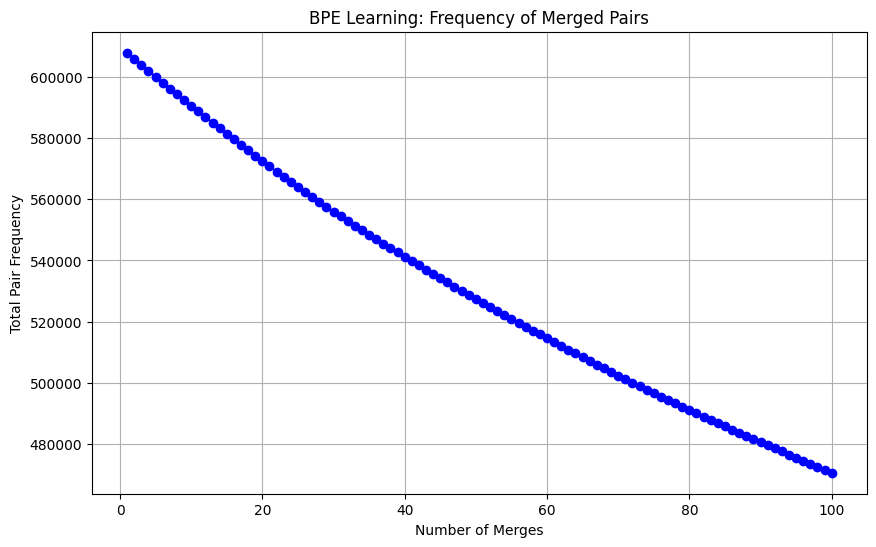

In [16]:
# Visualize BPE learning
visualize_bpe_learning(bpe)